## Importing and parsing the XML file

We start with importing the required libraries:

In [2]:
import warnings
warnings.filterwarnings("ignore") # to ignore python warnings and cleam the output
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import seaborn as sns
from matplotlib import pyplot as plt
import re
import pycats

We use Element Tree library to open the XML. You can replicate the same on your end by exporting your `Library.xml` file from your Apple Music by going to `File > Library > Export Library`.

We can load an XML string into an `ElementTree` object using the `ET.parse()` function. This function structures the data in a tree format, reflecting the hierarchical nature of XML files.

To start exploring the tree, we extract its root using the `getroot()` method. From this root, we can navigate through the entire tree.

In [3]:
tree = ET.parse('Library.xml')
root = tree.getroot()

At this point, I think it helps to take a look at the first lines of the XML to have an idea of how it actually looks like:

``` xml
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE plist PUBLIC "-//Apple Computer//DTD PLIST 1.0//EN" "http://www.apple.com/DTDs/PropertyList-1.0.dtd">
<plist version="1.0">
<dict>
	<key>Major Version</key><integer>1</integer>
	<key>Minor Version</key><integer>1</integer>
	<key>Date</key><date>2024-07-20T09:07:45Z</date>
	<key>Application Version</key><string>1.4.5.36</string>
	<key>Features</key><integer>5</integer>
	<key>Show Content Ratings</key><true/>
	<key>Music Folder</key><string>file:///Users/vedantwalia/Music/Music/Media.localized/</string>
	<key>Library Persistent ID</key><string>EC54F07D32172045</string>
	<key>Tracks</key>
	<dict>
		<key>7049</key>
		<dict>
			<key>Track ID</key><integer>7049</integer>
			<key>Name</key><string>About a Girl (Live Acoustic)</string>
			<key>Artist</key><string>Nirvana</string>
			<key>Album Artist</key><string>Nirvana</string>
			<key>Composer</key><string>Kurt Cobain</string>
			<key>Album</key><string>MTV Unplugged In New York (Live Acoustic)</string>
			<key>Genre</key><string>Alternative</string>
			<key>Kind</key><string>Apple Music AAC audio file</string>
			<key>Size</key><integer>8322403</integer>
			<key>Total Time</key><integer>218000</integer>
			<key>Disc Number</key><integer>1</integer>
			<key>Disc Count</key><integer>1</integer>


Nodes in XML files, such as root, usually have a tag and a dictionary of attributes. 
We can get these with the following code:

In [8]:
root.tag

'plist'

In [9]:
root.attrib

{'version': '1.0'}

From the above informaton we can discern that the dataset is a plist.

From a visual inspection of the data above we can that all the information is nested under the key `Tracks`.

Now we need to use Python to navigate to that part of the tree and extract the `Tracks` dict to convert it into a pandas DataFrame.

The following code does that, it iterates over the main dict until it finds the `Tracks` dict *(which can be recognized because it’s the first element with tag `<dict>` in the dataset)*. It then saves it in an variable `tracks_dict`.


In [7]:
main_dict=root.findall('dict')

for index, item in enumerate(list(main_dict[0])):  
    print('index #{} = <{}>'.format(index, item.tag))
    if item.tag=="dict":
        print('The tracks dict has been found!')
        tracks_dict=item
        break


index #0 = <key>
index #1 = <integer>
index #2 = <key>
index #3 = <integer>
index #4 = <key>
index #5 = <date>
index #6 = <key>
index #7 = <string>
index #8 = <key>
index #9 = <integer>
index #10 = <key>
index #11 = <true>
index #12 = <key>
index #13 = <string>
index #14 = <key>
index #15 = <string>
index #16 = <key>
index #17 = <dict>
The tracks dict has been found!


In [10]:
tracklist = list(tracks_dict.findall('dict'))
len(tracklist) #this gives out the number of tracks listed in the current snapshot of my library

6638

### Creating a Pandas DataFrame

Let us now organise the raw data into a proper data structure, a DataFrame.

This currently is an issue since the library contains mutiple formats of media files.

In [71]:
kinds = set([])
for i in range(len(tracklist)):
    for j in range(len(tracklist[i])):
        if (tracklist[i][j].tag == 'key' and tracklist[i][j].text== 'Kind'):
            kinds.add(tracklist[i][j+1].text)

kinds = pd.Series(list(kinds))
kinds

0    Apple Music AAC audio file
1                AAC audio file
2               MPEG audio file
3      Purchased AAC audio file
4             MPEG-4 video file
dtype: object

Since I don't need video files, I filter them out.

In [72]:
valid_datatypes = pd.Series([
    'AAC audio file',
    'MPEG audio file',
    'MPEG audio file',
    'Apple Music AAC audio file'
])

Since there is a variance in the data type and 

In [11]:
# This code will retrieve all the 'keys' (attributes) of the first track of the corresponding Kind
def cols(kind):
    cols = []
    kind_found = False
    for i in range(len(tracklist)):
        for j in range(len(tracklist[i])):
            if tracklist[i][j].tag == "key":
                cols.append(tracklist[i][j].text)
            if (j < len(tracklist[i]) - 1 and tracklist[i][j].text == "Kind" and tracklist[i][j + 1].text == kind):
                kind_found = True
                break  # Once the kind is found, break the inner loop
        if kind_found:
            return set(cols)  # Return the set of columns if kind is found

In [74]:
results = map(cols, valid_datatypes)
results_list = [list(item) for item in results]
results_list

[['Play Count',
  'Track Number',
  'Total Time',
  'Sort Name',
  'Artwork Count',
  'Explicit',
  'Sort Album Artist',
  'Track ID',
  'Track Count',
  'Part Of Gapless Album',
  'Composer',
  'Disc Count',
  'Purchased',
  'Album Loved',
  'Release Date',
  'Sort Artist',
  'Date Added',
  'Skip Date',
  'Name',
  'Genre',
  'Bit Rate',
  'Sort Composer',
  'Clean',
  'Album Artist',
  'Year',
  'Playlist Only',
  'Kind',
  'Compilation',
  'Play Date UTC',
  'Artist',
  'Loved',
  'Normalization',
  'Disc Number',
  'Date Modified',
  'Skip Count',
  'Sample Rate',
  'Track Type',
  'Apple Music',
  'Favorited',
  'Size',
  'Play Date',
  'Sort Album',
  'Album',
  'Persistent ID'],
 ['Play Count',
  'Track Number',
  'Total Time',
  'Sort Name',
  'Artwork Count',
  'Explicit',
  'Grouping',
  'Sort Album Artist',
  'Track ID',
  'Track Count',
  'Part Of Gapless Album',
  'Composer',
  'Disc Count',
  'Purchased',
  'Album Loved',
  'Release Date',
  'Sort Artist',
  'Date Added'

In [75]:
# Initialize an empty list to store flattened items
flat_list = []

# Iterate over each item in the results_list
for item in results_list:
    for sub_item in item:
        flat_list.append(sub_item)

# Convert the flat_list to a set to get unique items
unique_cols = set(flat_list)

print(unique_cols)


{'Size', 'Play Count', 'Track Number', 'Total Time', 'Sort Name', 'Artwork Count', 'Explicit', 'Grouping', 'Track ID', 'Track Count', 'Part Of Gapless Album', 'Composer', 'Disc Count', 'Purchased', 'Album Loved', 'Release Date', 'Sort Artist', 'Date Added', 'Skip Date', 'Name', 'Genre', 'Bit Rate', 'Sort Composer', 'Clean', 'Album Artist', 'Year', 'Playlist Only', 'Kind', 'Compilation', 'Play Date UTC', 'Artist', 'Loved', 'Normalization', 'Disc Number', 'Date Modified', 'Skip Count', 'Sample Rate', 'Track Type', 'Apple Music', 'Favorited', 'Matched', 'Sort Album Artist', 'Play Date', 'Sort Album', 'Album', 'Persistent ID'}


In [76]:
len(unique_cols) # superset of all common unique entries between all the filetypes -- gives the number of common entries

46


The following bit of code extracts data from the XML file and creates a DataFrame using the extracted information. The XML file contains the list of songs, each with various attributes such as track ID, name, artist, album, genre, etc.

The goal is to parse this XML file, extract relevant attributes, and store them in a structured DataFrame for further analysis.

#### Steps:

1. **Convert Unique Columns to List**: The first step involves converting a set of unique column names to a list. This set of unique columns represents all possible attributes found in the XML file.

2. **Initialize DataFrame**: An empty DataFrame is created with columns derived from the unique column list obtained in the previous step. This DataFrame will store the extracted data from the XML file.

3. **Iterate Through XML Elements**: The code iterates through each song element in the XML file. For each song, it further iterates through its attributes.

4. **Extract Attributes**: Within the nested loops, attributes such as track ID, name, artist, etc., are extracted from the XML elements and store it in a dictionary named `attributes_dict`.

5. **Check Validity of 'Kind' Attribute**: After extracting all attributes for a song, the code checks if the 'Kind' attribute is among the valid data types. If it is valid, the data for that song is considered for inclusion in the DataFrame.

6. **Create Temporary DataFrame**: For each valid song, a temporary DataFrame is created with the extracted attributes as columns and their corresponding values as rows.

7. **Concatenate DataFrames**: Finally, the temporary DataFrame for each song is concatenated with the main DataFrame, `df_tracks` to aggregate all the extracted data.



In [77]:
# Convert the set of unique columns to a list
unique_cols_list = list(unique_cols)

# Create an empty DataFrame with columns from the unique columns list
df_tracks = pd.DataFrame(columns=unique_cols_list)

# Initialize an empty dictionary
dict = { }

# Iterate over each song in the tracklist
for song_i in range(len(tracklist)):
    # Iterate over each attribute in the current song
    for attribute_i in range(len(tracklist[song_i])):
        # Check if the current attribute is "key"
        if tracklist[song_i][attribute_i].tag == "key":
            # Add the key-value pair to the dictionary
            dict[tracklist[song_i][attribute_i].text] = tracklist[song_i][attribute_i + 1].text
    
    # Extract values and keys from the dictionary
    list_values = [i for i in dict.values()]
    list_keys = [j for j in dict.keys()]
    
    # Check if the 'Kind' attribute is in the valid_datatypes.unique()
    if dict['Kind'] in valid_datatypes.unique():
        # Create a temporary DataFrame for the current song
        df_temp = pd.DataFrame([list_values], columns=list_keys)
        # Concatenate the temporary DataFrame with df_tracks
        df_tracks = pd.concat([df_tracks, df_temp], axis=0, ignore_index=True, sort=True)


Please note that this code is very inefficient, probably because it does a DataFrame `concat` for each song in `tracklist`. I will leave it like that because it doesn’t take long to run anyway (since my data is relatively small). But don’t use it as a reference for anything. 

I now have a DataFrame with all my songs, so I can use all the pandas’ functions and methods to manipulate and analyze them.

In [78]:
df_tracks[['Play Count']] = df_tracks[['Play Count']].apply(pd.to_numeric)

In [79]:
top_songs=(df_tracks.sort_values(by='Play Count', ascending=False)[['Name', 'Artist', 'Play Count', 'Genre']])

top_songs

,Name,Artist,Play Count,Genre
4371,Save Your Tears (Remix),The Weeknd & Ariana Grande,114.0,R&B/Soul
4672,Self Love (Spider-Man: Across the Spider-Verse),Metro Boomin & Coi Leray,100.0,Hip-Hop/Rap
4326,"Wish On An Eyelash, Pt. 2",Mallrat & The Chainsmokers,87.0,Alternative
4292,Eyes Wide Shut,"ILLENIUM, Avril Lavigne & Travis Barker",80.0,Dance
4628,Electric Touch (Taylor's Ve rsion) (From The V...,Taylor Swift,70.0,Pop
...,...,...,...,...
118,Words Can't Describe,Flourish & Jack Howard,NaN,Pop
119,The Stranger,Ingrid Andress,NaN,Country
120,Chemical,Post Malone,NaN,Pop
121,Gangsta's Paradise (feat. L.V.),Coolio,NaN,Hip-Hop/Rap


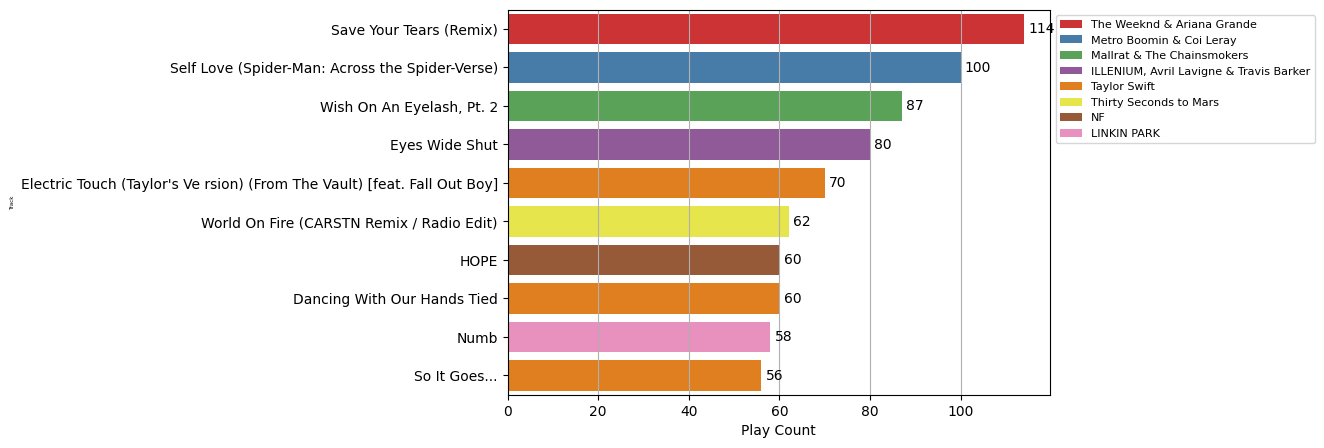

In [80]:
plt.clf()
ax=sns.barplot(x='Play Count',
            y='Name',
            hue='Artist',
            data=top_songs.head(10),
            dodge=False,
            palette=sns.color_palette("Set1"))
ax.figure.set_size_inches(7,5)
ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
ax.xaxis.grid(True)
ax.set_ylabel('Track', fontsize=4)
#plt.savefig('test.png', dpi=400)

#Adding the values on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.show()

In [81]:
ntracks_album=df_tracks.groupby('Album').size()
full_albums=(ntracks_album[ntracks_album>5]
             .reset_index()
             .rename(columns={0: "n_tracks"}))
full_albums

,Album,n_tracks
0,#3,9
1,(What's the Story) Morning Glory? [Deluxe Edit...,9
2,1989 (Taylor's Version),21
3,=,14
4,A Head Full Of Dreams,9
...,...,...
146,misery lake - EP,6
147,no future,19
148,reputation,7
149,vertigo,13


In [82]:
plays_by_album=(df_tracks
                .groupby('Album')['Play Count']
                .sum()
                .reset_index()
                .sort_values(by='Play Count', ascending=False))

full_albums_ranked=plays_by_album[plays_by_album.Album.isin(full_albums.Album)]
full_albums_ranked.head(10)

,Album,Play Count
1603,ILLENIUM,317.0
1982,METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE S...,303.0
3918,reputation,282.0
1070,Fallen Embers (Deluxe Version),206.0
2888,Speak Now (Taylor's Version),190.0
520,Blurryface,163.0
2093,Moon Music,142.0
689,Clancy,142.0
1575,I met you when I was 18. (the playlist),140.0
2707,Scaled And Icy (Livestream Version),134.0


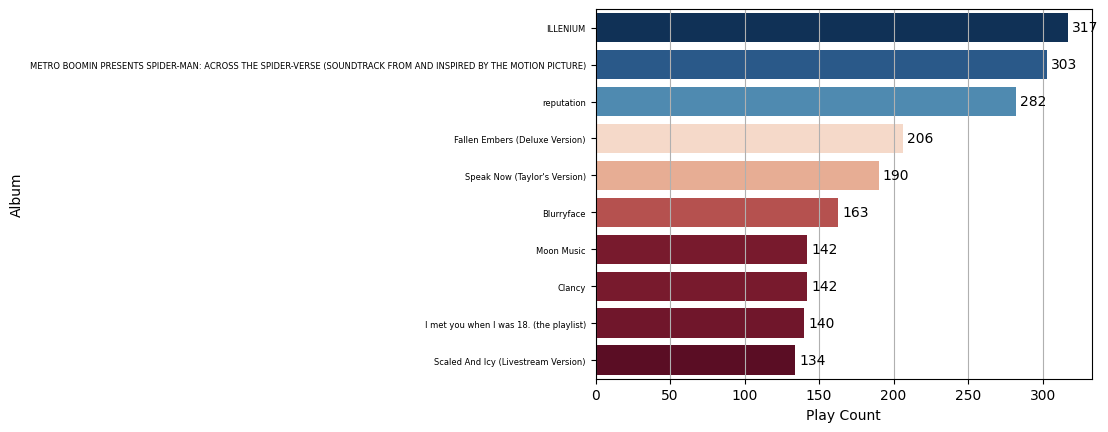

In [83]:
plt.clf()
ax=sns.barplot(x='Play Count',
               y='Album',
               hue='Play Count',
              data=full_albums_ranked.head(10),
              dodge='auto',
              palette='RdBu')
ax.tick_params(axis='y', labelsize=6)
ax.xaxis.grid(True)
ax.legend_.remove()

#Adding the values on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.show()

In [84]:
# Define a list of delimiters to split the Artist column
delimiters = [' & ', ',', ' Feat. ', ' feat. ', '/', ' feat ', 'Feat']
# Escape special characters in the delimiters and join them into a regex pattern
regexPattern = '|'.join(map(re.escape, delimiters))
# Compile the regex pattern into a regex object
reg_split = re.compile(regexPattern)

# Split the Artist column using the regex pattern and store the result in artists_splitted
artists_splitted = df_tracks.Artist.str.split(regexPattern)

# Return the result
artists_splitted


0                                     [Nirvana]
1                               [Fleetwood Mac]
2                                 [Michigander]
3                               [You Me At Six]
4                                [Zara Larsson]
                         ...                   
6612                                [Joe Jonas]
6613                             [Rise Against]
6614                    [Clean Bandit, Piso 21]
6615    [Tech N9ne Collabos,  Tech N9ne, C-Mob]
6616                                      [War]
Name: Artist, Length: 6617, dtype: object

In [85]:
songs=[]
for i, song in df_tracks.Name.items():
  ## Parse the artists of the song
  if df_tracks.Artist.values[i]=='Now, Now':
    artist_to_assign=[df_tracks.Artist.values[i]]
  else:
    artist_to_assign=artists_splitted.values[i]
  
  ## add elements to the list of songs
  songs.append({'Name': song,
                'Number': i,
                'Artists': artist_to_assign})

songs[:5]

[{'Name': 'About a Girl (Live Acoustic)', 'Number': 0, 'Artists': ['Nirvana']},
 {'Name': 'Go Your Own Way', 'Number': 1, 'Artists': ['Fleetwood Mac']},
 {'Name': 'Cannonball', 'Number': 2, 'Artists': ['Michigander']},
 {'Name': 'SUCKAPUNCH', 'Number': 3, 'Artists': ['You Me At Six']},
 {'Name': "Can't Tame Her", 'Number': 4, 'Artists': ['Zara Larsson']}]

In [86]:
artists={}

for i in range(len(songs)):
  for j in range(len(songs[i]['Artists'])):
    if songs[i]['Artists'][j] not in artists:
      artists[songs[i]['Artists'][j]]=df_tracks['Play Count'][i]
    else:
      artists[songs[i]['Artists'][j]]+=df_tracks['Play Count'][i]

df_artists_plays=pd.DataFrame(artists.items(),
                              columns=['Artist', 'Play Count'])

df_artists_plays = df_artists_plays.dropna()

df_artists_plays.head(5)

,Artist,Play Count
117,Lauv,373.0
118,The Local Train,87.0
119,Kygo,169.0
120,Ed Sheeran,193.0
121,ILLENIUM,894.0


In [87]:
df_artists_plot=(df_artists_plays
                 .sort_values(by='Play Count', ascending=False)
                 .head(10))

df_artists_plot

,Artist,Play Count
378,Taylor Swift,1139.0
121,ILLENIUM,894.0
123,twenty one pilots,730.0
356,Coldplay,503.0
153,LINKIN PARK,463.0
395,OneRepublic,430.0
145,Logic,417.0
138,Eminem,399.0
117,Lauv,373.0
385,Imagine Dragons,361.0


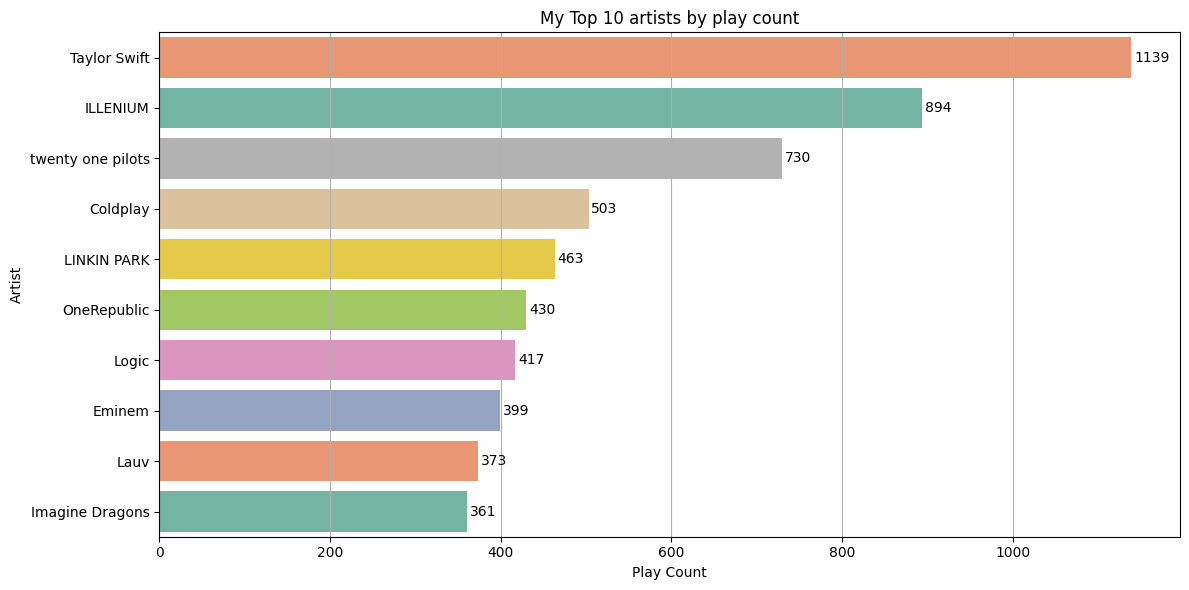

In [88]:
plt.clf()
ax=sns.barplot(x='Play Count',
               y='Artist',
               hue='Play Count',
              data=df_artists_plot,
              dodge=False,
              palette='Set2')

# Rotating labels trying to make them fit
ax.figure.set_size_inches(12,6)
ax.xaxis.grid(True)

#Adding the values on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=2)

plt.title('My Top 10 artists by play count')
plt.tight_layout()
plt.legend([],[], frameon=False)

plt.show()

In [89]:
df_tracks[['Year']]=df_tracks[['Year']].apply(pd.to_numeric)

df_tracks=(df_tracks.assign(FiveYearPeriod=pd.to_numeric(np.floor(df_tracks.Year / 5) * 5, downcast='integer')))

In [90]:
df_tracks.groupby("FiveYearPeriod").size()


FiveYearPeriod
1900       1
1945       1
1950       1
1955       5
1960       6
1965      54
1970     102
1975     133
1980     137
1985     118
1990     131
1995     158
2000     418
2005     540
2010    1155
2015    1455
2020    2202
dtype: int64

In [91]:
df_tracks.FiveYearPeriod=['Before 1995' if year < 1995 else year for year in df_tracks.FiveYearPeriod]

In [92]:
cat_years=pd.Categorical(df_tracks.FiveYearPeriod,
               ordered=True,
               categories=['Before 1995', 1995, 2000, 2005, 2010, 2015, 2020])

df_tracks.FiveYearPeriod=cat_years.rename_categories({1995: '1995-1999', 2000: '2000-2004', 2005: '2005-2009', 2010: '2010-2014', 2015: '2015-2019', 2020: '2020-Present'})

In [93]:
songs_period=df_tracks.groupby(['FiveYearPeriod']).size()
#songs_period = songs_period.fillna(0)
songs_period

FiveYearPeriod
Before 1995      689
1995-1999        158
2000-2004        418
2005-2009        540
2010-2014       1155
2015-2019       1455
2020-Present    2202
dtype: int64

In [94]:
plays_period=df_tracks.groupby(['FiveYearPeriod'])['Play Count'].mean()
plays_period = plays_period.fillna(0)
plays_period

FiveYearPeriod
Before 1995     5.021116
1995-1999       6.188312
2000-2004       5.300971
2005-2009       5.616257
2010-2014       4.153240
2015-2019       5.325000
2020-Present    7.663881
Name: Play Count, dtype: float64

<Figure size 640x480 with 0 Axes>

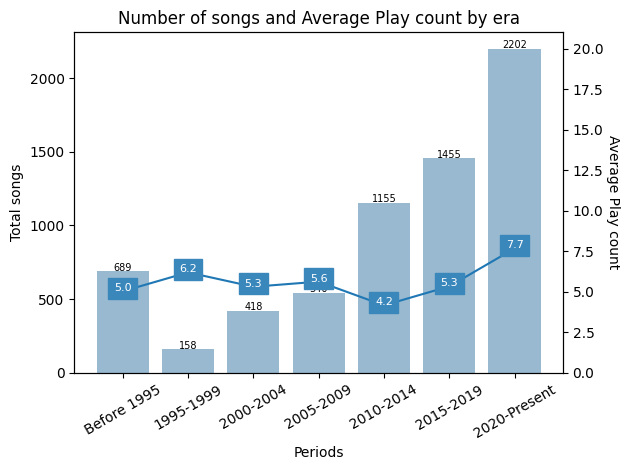

In [95]:
plt.clf()
fig, ax1 = plt.subplots()
sns1=sns.barplot(x=songs_period.index, y=songs_period.values, alpha=0.5)

# Adding labels to bar plot
for a, b in zip(songs_period.index, songs_period.values):
  plt.text(x = a, y = b+5, s = '{:.0f}'.format(b), size=7, color='black', ha='center')


ax2 = ax1.twinx()
sns2=sns.lineplot(x=plays_period.index, y=plays_period.values, marker='o')
sns2.set_ylim(0, 21)

sns1.set(xlabel='Periods', ylabel='Total songs')
sns2.set_ylabel('Average Play count', rotation=270, labelpad=12.0)
sns1.set_xticklabels(sns1.get_xticklabels(),rotation = 30)

# Adding labels to line plot
for x, y in zip(plays_period.index, plays_period.values):
  plt.text(x = x, y = y, s = '{:.1f}'.format(y), size=8, color='white', ha='center').set_backgroundcolor('#3A87BC')

sns1.set(title='Number of songs and Average Play count by era')
plt.tight_layout()
plt.savefig('fig_two_plot.png')
plt.show()

In [96]:
df_tracks['Genres_lumped']=pycats.cat_lump(pycats.as_cat(df_tracks['Genre']), 4)
df_tracks['Genres_lumped'].value_counts()

Genres_lumped
Other          1999
Pop            1871
Alternative    1452
Rock            946
Dance           349
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

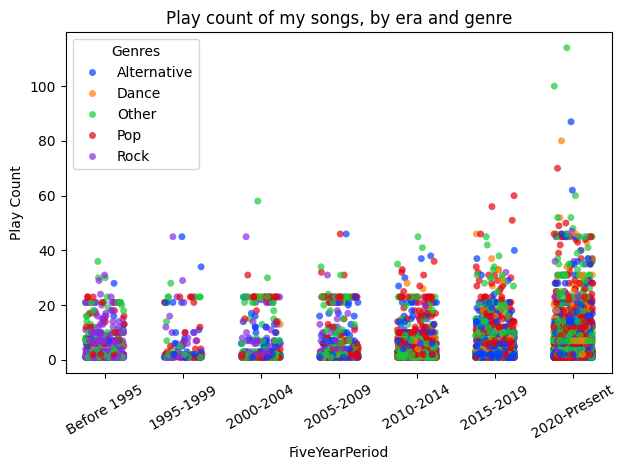

In [97]:
plt.clf()
plt.figure()

# Draw a categorical scatterplot to show each observation
ax = sns.stripplot(data=df_tracks, y="Play Count", x="FiveYearPeriod", hue="Genres_lumped", size=5, alpha=0.7, jitter=0.25, palette='bright')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.legend(title='Genres')
plt.title('Play count of my songs, by era and genre')
plt.tight_layout()
plt.show()

In [98]:
def top_songs(df, n=3, column='Play Count'):
  return df.sort_values(by=column, ascending=False)[:n]


top_songs_per_era=(df_tracks
                   .groupby('FiveYearPeriod')
                   .apply(top_songs)
                   [['Album', 'Artist', 'Name', 'Play Count', 'FiveYearPeriod', 'Genres_lumped']])

In [99]:
# Reset index to avoid ambiguity
top_songs_per_era.reset_index(drop=True, inplace=True)

# Select columns and rename them
df = top_songs_per_era.rename(columns={
    'FiveYearPeriod': 'FiveYearPeriod',
    'Name': 'Song',
    'Album': 'Album',
    'Artist': 'Artist',
    'Play Count': 'Play Count',
    'Genres_lumped': 'Genre'
})

# Group by FiveYearPeriod and add row number
df['row_n'] = df.groupby('FiveYearPeriod').cumcount() + 1

# Add Era column based on row number
df['Era'] = df.apply(lambda row: '' if row['row_n'] > 1 else str(row['FiveYearPeriod']), axis=1)

# Hide Era column
df = df.drop(columns=['row_n', 'Era'])

# Style cells
def style_cells(row):
    if row['Genre'] == 'Alternative':
        return ['background-color: #fff7e5'] * len(row)
    elif row['Genre'] == 'Pop':
        return ['background-color: #ebf0fa'] * len(row)
    elif row['Genre'] == 'Rock':
        return ['background-color: #faebeb'] * len(row)
    elif row['Genre'] == 'Urbano latino':
        return ['background-color: #f5edf7'] * len(row)
    elif row['Genre'] == 'Other':
        return ['background-color: #f2f2f2'] * len(row)
    else:
        return [''] * len(row)

styled_df = df.style.apply(style_cells, axis=1)
styled_df.set_properties(**{'background-color': 'transparent'})


# Set table header, source note, header, footnote
styled_df.set_caption("My favourite songs across different eras")
styled_df.set_table_styles([{
    'selector': 'caption',
    'props': [('font-weight', 'bold')]
}])
styled_df.set_caption("My favourite songs across different eras")

# Print styled DataFrame
styled_df

,Album,Artist,Song,Play Count,FiveYearPeriod,Genre
0,River of Jordan,The Carter Family,Wildwood Flower,36.000000,Before 1995,Other
1,Eliminator,ZZ Top,Gimme All Your Lovin',31.000000,Before 1995,Rock
2,Back In Black,AC/DC,Back In Black,30.000000,Before 1995,Other
3,Prolonging the Magic (Deluxe Version),CAKE,Never There,45.000000,1995-1999,Alternative
4,311,311,Down,45.000000,1995-1999,Rock
5,Third Eye Blind,Third Eye Blind,Semi-Charmed Life,34.000000,1995-1999,Alternative
6,Meteora (Deluxe Edition),LINKIN PARK,Numb,58.000000,2000-2004,Other
7,Absolution,Muse,Hysteria,45.000000,2000-2004,Rock
8,Nellyville (Deluxe Edition),Nelly,Dilemma (feat. Kelly Rowland),31.000000,2000-2004,Pop
9,Cage the Elephant (Expanded Edition),Cage the Elephant,Back Against the Wall,46.000000,2005-2009,Alternative
